# Data Cleaning Pipeline

In [1]:
# Only need to assign the two values below first, then run all
watershed = 'HubbardBrook'
main_str = 'WS7'

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import copy
from pandas.plotting import register_matplotlib_converters
from sklearn import linear_model
from sklearn.metrics import r2_score
import copy
import os
import matplotlib.backends.backend_pdf
lm = linear_model.LinearRegression()
np.random.seed(50)
plt.rcParams.update({'figure.max_open_warning': 0})
register_matplotlib_converters()
os.getcwd()

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/13-Hubbard/DailyData'

In [3]:
# local functions
import sys
sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')

from Abnormal_data_values_control import outvalues,threC
from Source_QC_functions_L import interpolateQC, regressorFunc, funcClimateCatalog, AssembleClimateCatalog

In [4]:
# Read the original data table
table = pd.read_csv('1_'+watershed+'_Download_Aggregation_Daily.csv',header = 0,index_col = 'DateTime',
                    parse_dates = True, infer_datetime_format = True,low_memory=False)
display(table.head(2))
display(table.tail(2))

WS1_Discharge  WS2_Discharge  WS3_Discharge  WS4_Discharge  \
DateTime                                                                 
1955-01-01            NaN            NaN            NaN            NaN   
1955-01-02            NaN            NaN            NaN            NaN   

            WS5_Discharge  WS6_Discharge  WS7_Discharge  WS8_Discharge  \
DateTime                                                                 
1955-01-01            NaN            NaN            NaN            NaN   
1955-01-02            NaN            NaN            NaN            NaN   

            WS9_Discharge  WS1_Precipitation  ...  STA14_AirTemperature  \
DateTime                                      ...                         
1955-01-01            NaN                NaN  ...                 -16.0   
1955-01-02            NaN                NaN  ...                   NaN   

            STA1A_AirTemperature  STAHQ_AirTemperature  STA23_AirTemperature  \
DateTime                                                                       
1955-01-01                 -13.0                 -10.0                   NaN   
1955-01-02                   NaN                   NaN                   NaN   

            STA17_AirTemperature  STA24_AirTemperature  STAHQ_SolarRadiation  \
DateTime                                                                       
1955-01-01                   NaN                   NaN                   NaN   
1955-01-02                   NaN                   NaN                   NaN   

            STAHQ_WindDirection  STAHQ_WindSpeed  STAHQ_VaporPressure  
DateTime                                                               
1955-01-01                  NaN              NaN                  NaN  
1955-01-02                  NaN              NaN                  NaN  

[2 rows x 30 columns]

WS1_Discharge  WS2_Discharge  WS3_Discharge  WS4_Discharge  \
DateTime                                                                 
2017-10-07            0.0            0.0       0.250000       0.171250   
2017-10-08            0.0            0.0       0.353264       0.324896   

            WS5_Discharge  WS6_Discharge  WS7_Discharge  WS8_Discharge  \
DateTime                                                                 
2017-10-07          0.000       0.086979       0.570000       0.450000   
2017-10-08          0.015       0.187639       1.090417       0.668889   

            WS9_Discharge  WS1_Precipitation  ...  STA14_AirTemperature  \
DateTime                                      ...                         
2017-10-07       1.053333                NaN  ...                   NaN   
2017-10-08       1.276806                NaN  ...                   NaN   

            STA1A_AirTemperature  STAHQ_AirTemperature  STA23_AirTemperature  \
DateTime                                                                       
2017-10-07                   NaN                   NaN                   NaN   
2017-10-08                   NaN                   NaN                   NaN   

            STA17_AirTemperature  STA24_AirTemperature  STAHQ_SolarRadiation  \
DateTime                                                                       
2017-10-07                   NaN                   NaN                   NaN   
2017-10-08                   NaN                   NaN                   NaN   

            STAHQ_WindDirection  STAHQ_WindSpeed  STAHQ_VaporPressure  
DateTime                                                               
2017-10-07                  NaN              NaN                  NaN  
2017-10-08                  NaN              NaN                  NaN  

[2 rows x 30 columns]

In [5]:
# Check all the station names
all_stations = table.columns.str.extract(r'([^_]+)')[0]
print('All stations names: ', all_stations.unique())
print ('  ')
nameStrflwStation=[]
nameHydrMetStation=[]
for i in np.arange(len(table.columns)):
    if table.columns[i][-9:]=='Discharge':  ### 
        if not all_stations[i] in nameStrflwStation:
            nameStrflwStation.append(all_stations[i]) ### 
    else:
        if not all_stations[i] in nameHydrMetStation:
            nameHydrMetStation.append(all_stations[i])  ### 

print('Discharge stations :',nameStrflwStation)
print('  ')
print('Meteorology stations:',nameHydrMetStation)                  

All stations names:  ['WS1' 'WS2' 'WS3' 'WS4' 'WS5' 'WS6' 'WS7' 'WS8' 'WS9' 'STA1' 'STA6'
 'STA14' 'STA1A' 'STAHQ' 'STA23' 'STA17' 'STA24']
  
Discharge stations : ['WS1', 'WS2', 'WS3', 'WS4', 'WS5', 'WS6', 'WS7', 'WS8', 'WS9']
  
Meteorology stations: ['WS1', 'WS2', 'WS3', 'WS4', 'WS5', 'WS6', 'WS7', 'WS8', 'WS9', 'STA1', 'STA6', 'STA14', 'STA1A', 'STAHQ', 'STA23', 'STA17', 'STA24']


In [6]:
for i in table.columns:
    if i.split('_')[0] == main_str :
        print(i)

WS7_Discharge
WS7_Precipitation


In [7]:
len(nameHydrMetStation)

17

#  1. Trim the original table

In [8]:
# Trim the data and let the table start with first non nan value, end with last non nan value
# Identify the first non nan value in each column as the starting date.
# Identify the last non nan value in each column as the ending date.

t = table.notna() 
t = ~np.isnan(table)
col = len(t.columns)
b = np.zeros([table.shape[1]])
c = np.array([table.shape[0]] * table.shape[1])

for i in range(col):
    if any(t.iloc[:,i]): # Since some are empty
        b[i] = list(np.where(t.iloc[:,i] == True))[0][0] # the first non nan value location
        c[i] = list(np.where(t.iloc[:,i] == True))[0][-1] # the last non nan value location
        
st_tab = b.min()
table1 = table.iloc[int(b.min()):int(c.max()) + 1,:] 

# Display the trimmed table
display(table1.head(2))
display(table1.tail(2))
print('trimmed row number is ', int(table.shape[0] -  table1.shape[0]))

WS1_Discharge  WS2_Discharge  WS3_Discharge  WS4_Discharge  \
DateTime                                                                 
1955-01-01            NaN            NaN            NaN            NaN   
1955-01-02            NaN            NaN            NaN            NaN   

            WS5_Discharge  WS6_Discharge  WS7_Discharge  WS8_Discharge  \
DateTime                                                                 
1955-01-01            NaN            NaN            NaN            NaN   
1955-01-02            NaN            NaN            NaN            NaN   

            WS9_Discharge  WS1_Precipitation  ...  STA14_AirTemperature  \
DateTime                                      ...                         
1955-01-01            NaN                NaN  ...                 -16.0   
1955-01-02            NaN                NaN  ...                   NaN   

            STA1A_AirTemperature  STAHQ_AirTemperature  STA23_AirTemperature  \
DateTime                                                                       
1955-01-01                 -13.0                 -10.0                   NaN   
1955-01-02                   NaN                   NaN                   NaN   

            STA17_AirTemperature  STA24_AirTemperature  STAHQ_SolarRadiation  \
DateTime                                                                       
1955-01-01                   NaN                   NaN                   NaN   
1955-01-02                   NaN                   NaN                   NaN   

            STAHQ_WindDirection  STAHQ_WindSpeed  STAHQ_VaporPressure  
DateTime                                                               
1955-01-01                  NaN              NaN                  NaN  
1955-01-02                  NaN              NaN                  NaN  

[2 rows x 30 columns]

WS1_Discharge  WS2_Discharge  WS3_Discharge  WS4_Discharge  \
DateTime                                                                 
2017-10-07            0.0            0.0       0.250000       0.171250   
2017-10-08            0.0            0.0       0.353264       0.324896   

            WS5_Discharge  WS6_Discharge  WS7_Discharge  WS8_Discharge  \
DateTime                                                                 
2017-10-07          0.000       0.086979       0.570000       0.450000   
2017-10-08          0.015       0.187639       1.090417       0.668889   

            WS9_Discharge  WS1_Precipitation  ...  STA14_AirTemperature  \
DateTime                                      ...                         
2017-10-07       1.053333                NaN  ...                   NaN   
2017-10-08       1.276806                NaN  ...                   NaN   

            STA1A_AirTemperature  STAHQ_AirTemperature  STA23_AirTemperature  \
DateTime                                                                       
2017-10-07                   NaN                   NaN                   NaN   
2017-10-08                   NaN                   NaN                   NaN   

            STA17_AirTemperature  STA24_AirTemperature  STAHQ_SolarRadiation  \
DateTime                                                                       
2017-10-07                   NaN                   NaN                   NaN   
2017-10-08                   NaN                   NaN                   NaN   

            STAHQ_WindDirection  STAHQ_WindSpeed  STAHQ_VaporPressure  
DateTime                                                               
2017-10-07                  NaN              NaN                  NaN  
2017-10-08                  NaN              NaN                  NaN  

[2 rows x 30 columns]

trimmed row number is  0


### Drop columns without data

In [9]:
tt = copy.deepcopy(table1)
for dd in np.arange(len(tt.columns)):
    if all(pd.isna(tt.iloc[:,dd])):
        print('The empty column is ', dd,tt.columns[dd])
        table1.drop(columns = tt.columns[dd], axis=1, inplace = True)

var_number = table1.shape[1] 

if table1.shape[1]  == table.shape[1] :
    print('There are no empty columns!')

There are no empty columns!


### Save the original discharge table seperately

In [10]:
DischargeTable = pd.DataFrame(index = table1.index)
for i in np.arange(len(nameStrflwStation)):
    DischargeTable[nameStrflwStation[i]+'_Discharge'] = table1.loc[:,nameStrflwStation[i]+'_Discharge']

DischargeTable.to_csv('1_'+ watershed + '_DischargeTable.csv')

# 2. Data filling method: Interpolation

 
0 WS1_Discharge :No missing data!
1 WS2_Discharge index of interpolated length = 14
No filled values are out of original data range
 
2 WS3_Discharge index of interpolated length = 15
No filled values are out of original data range
 
3 WS4_Discharge index of interpolated length = 15
No filled values are out of original data range
 
4 WS5_Discharge index of interpolated length = 14
No filled values are out of original data range
 
5 WS6_Discharge index of interpolated length = 14
No filled values are out of original data range
 
6 WS7_Discharge index of interpolated length = 28
No filled values are out of original data range
 
7 WS8_Discharge index of interpolated length = 15
No filled values are out of original data range
 
 
8 WS9_Discharge :No missing data!
 
9 WS1_Precipitation :No missing data!
10 WS2_Precipitation index of interpolated length = 14
No filled values are out of original data range
 
11 WS3_Precipitation index of interpolated length = 14
No filled values are out of 

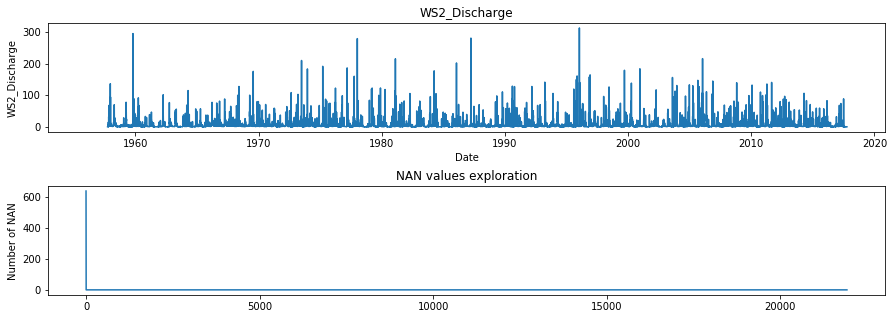

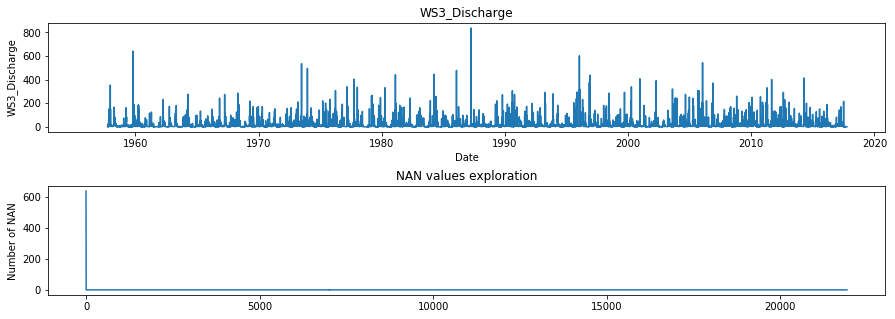

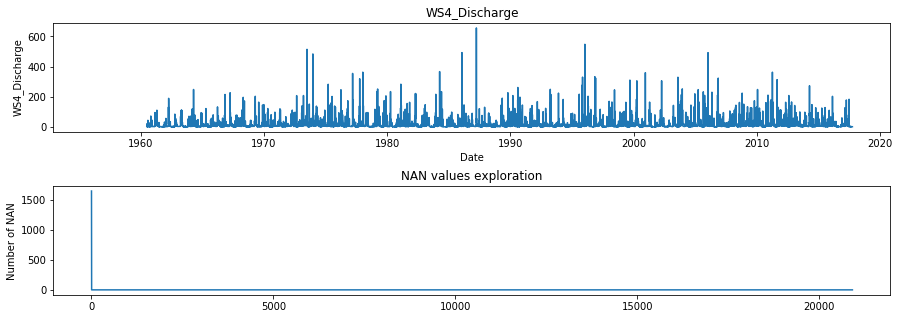

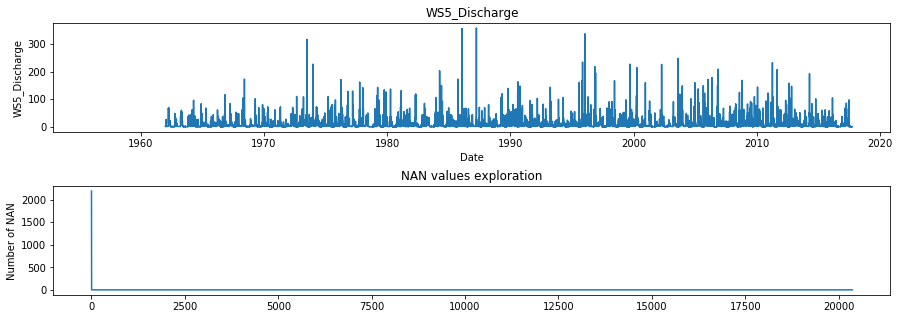

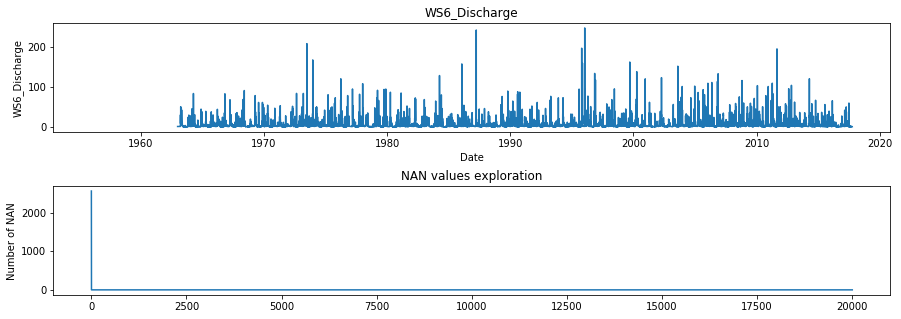

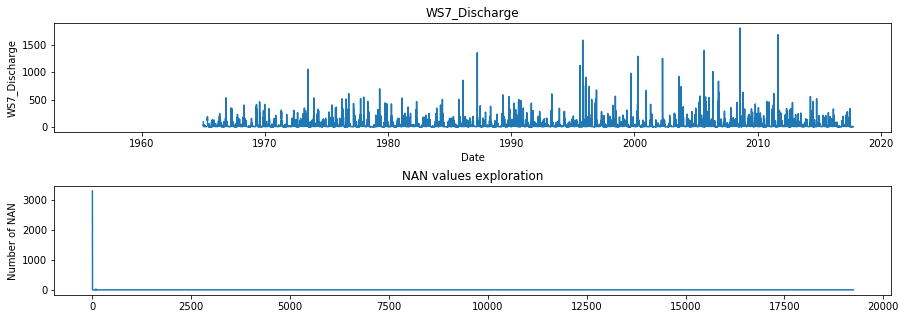

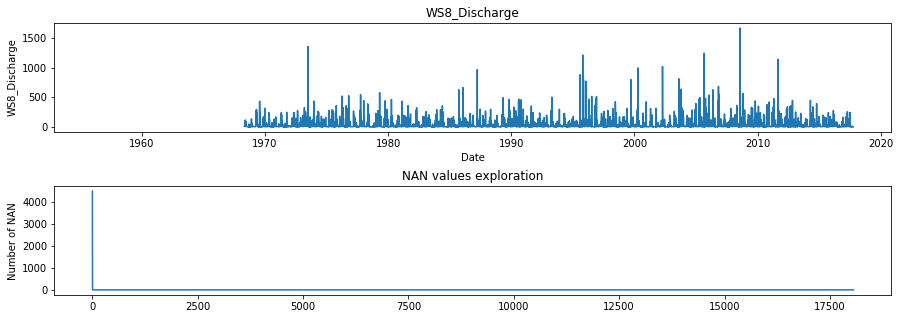

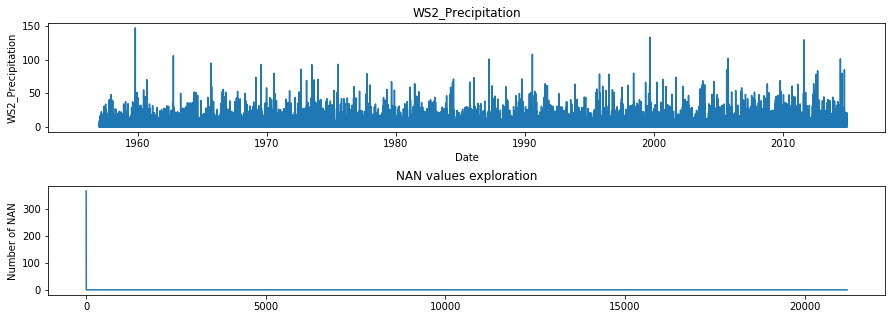

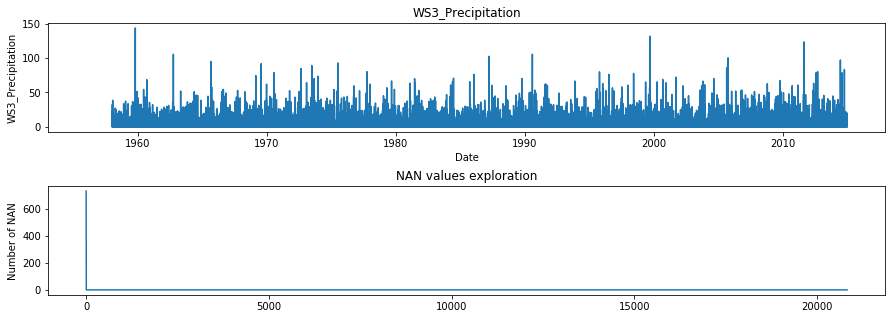

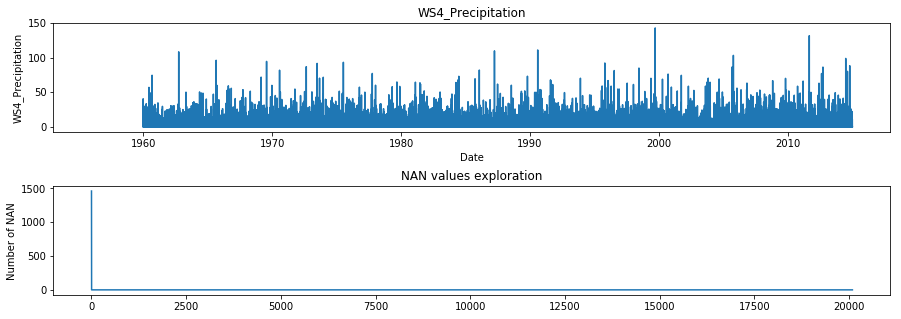

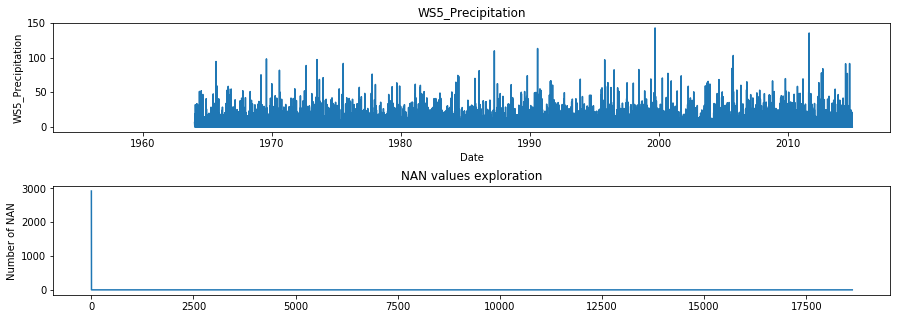

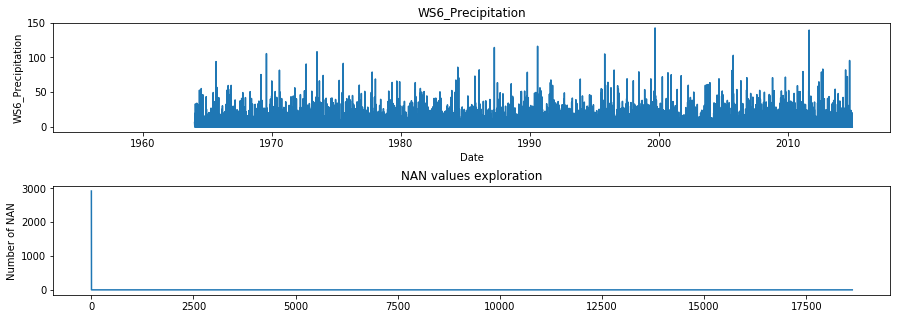

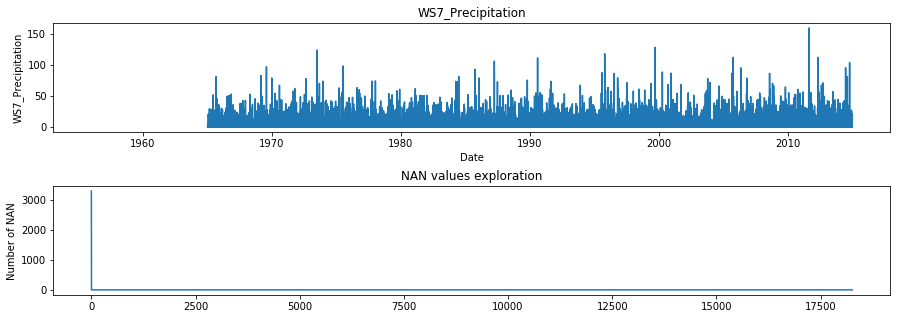

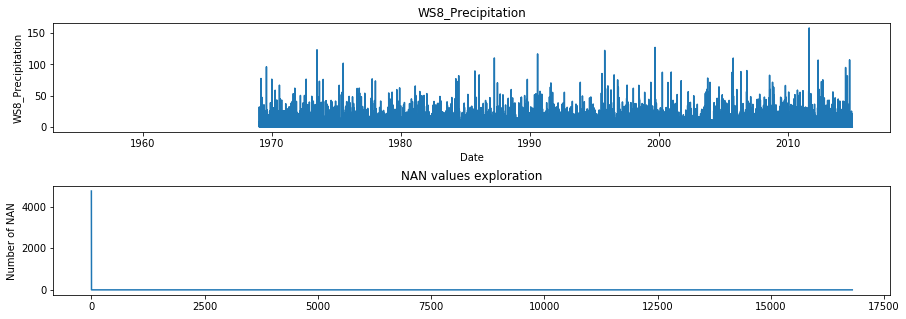

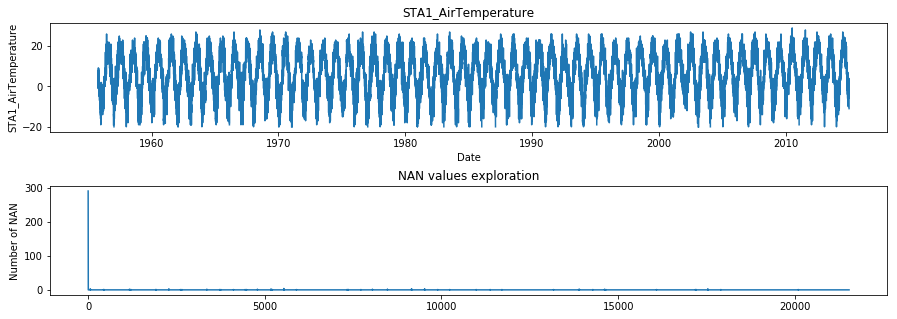

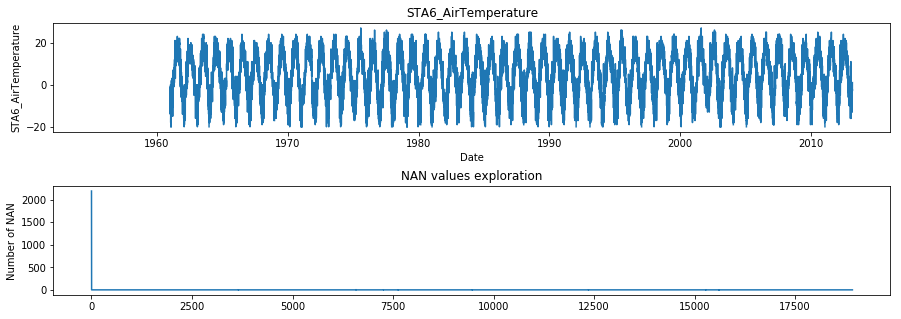

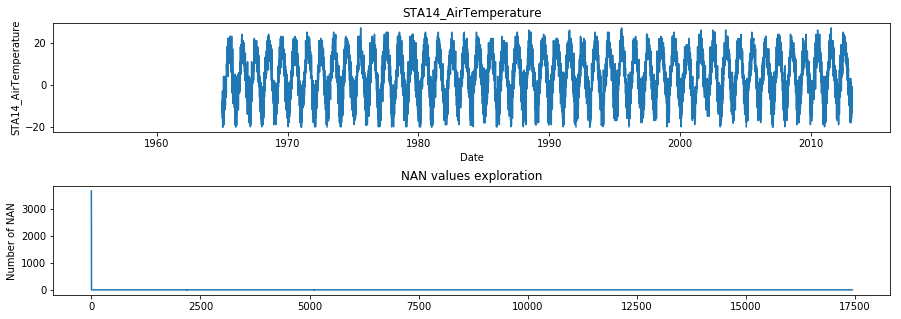

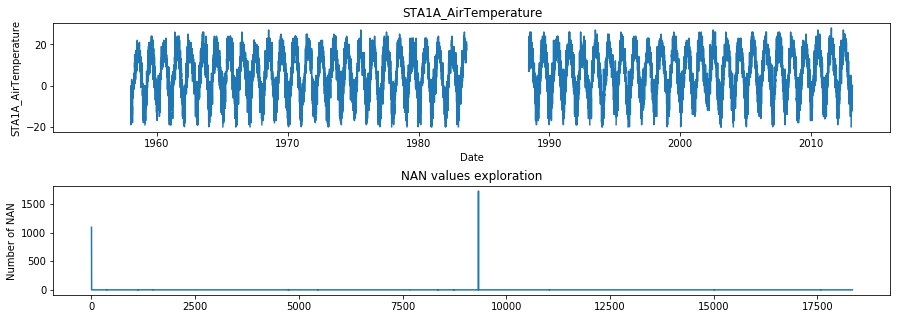

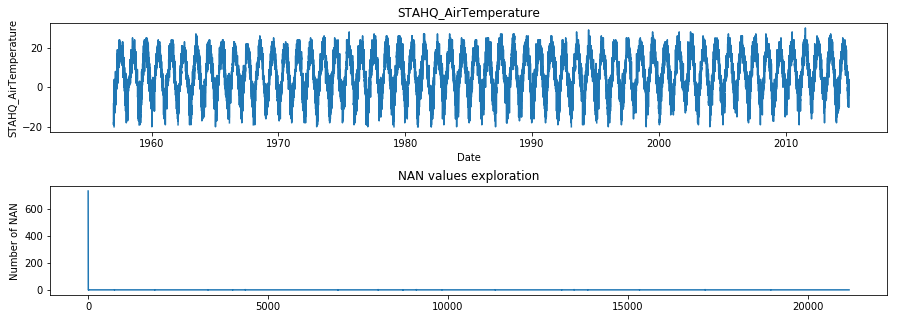

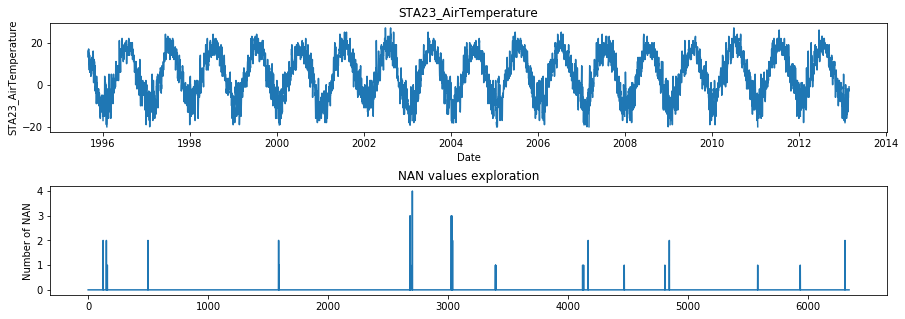

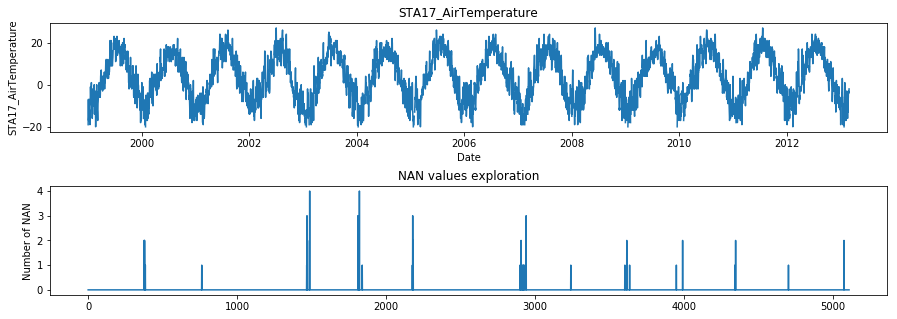

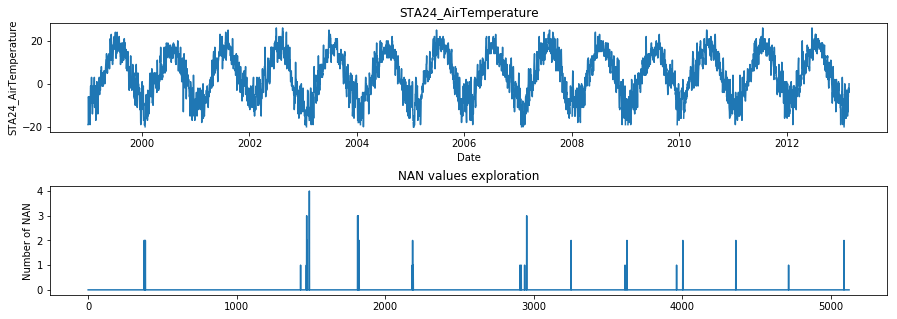

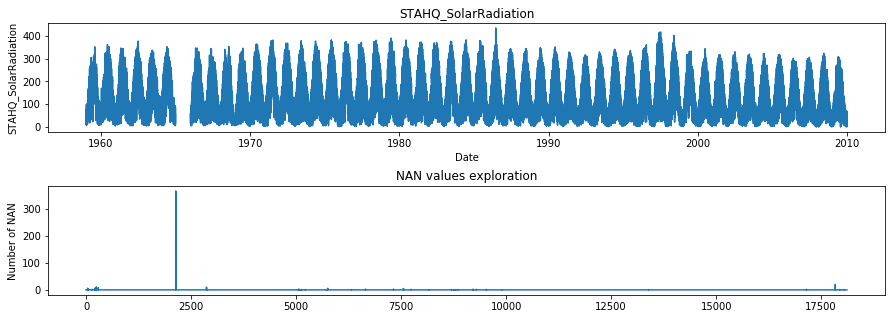

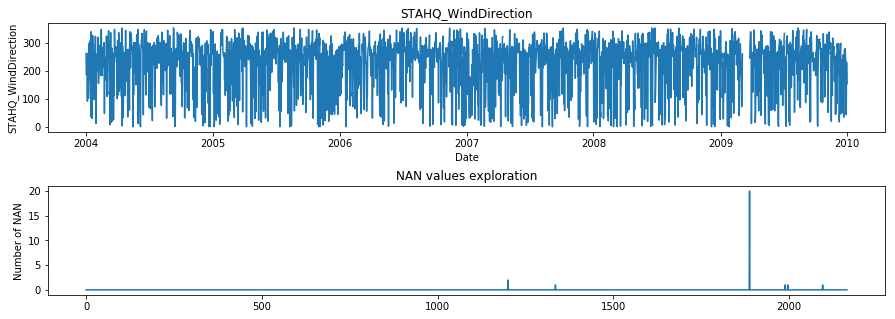

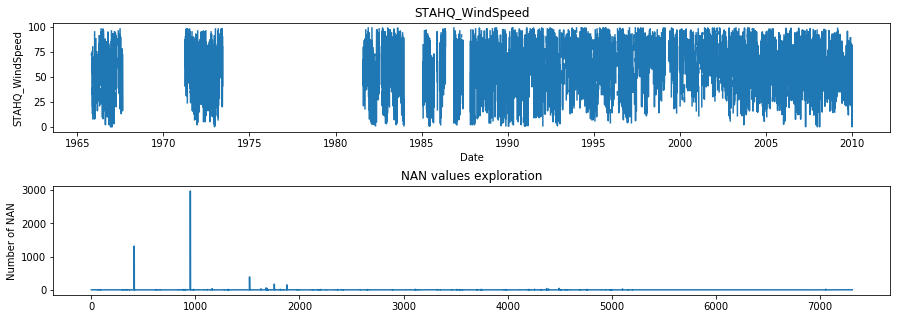

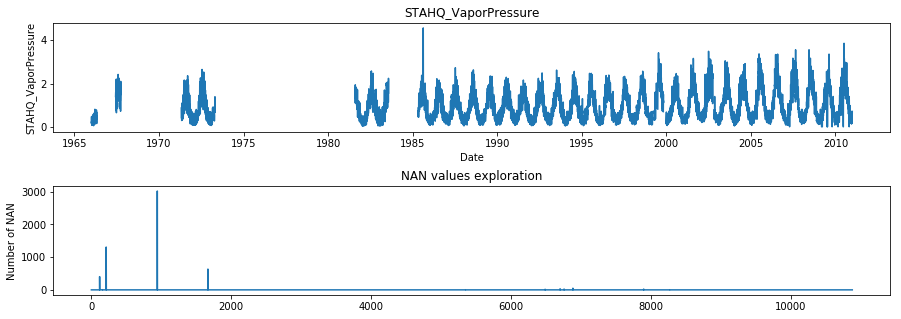

In [11]:
# =====================================
# First data exploration with plots.
# Check the number of Missing values.
# Do interpolation on the missing values positions

# table 2 will be used to be updated with interpolated values
table2=copy.deepcopy(table1) 

# a dictionary that store data record for each column
y1={} 

# Create a flag table(flag_table2) to store interpolation indicators
indexUnique=table2.index
ready_columns=pd.unique(table2.columns) 
if len(pd.unique(table2.columns))!=len(table2.columns):
    print("Duplicate columns exist!")
flag_table2=pd.DataFrame(np.nan*np.ones([len(indexUnique),len(ready_columns)]),
                 index = indexUnique, columns=ready_columns) 


for k,VarName in enumerate(ready_columns): # column of variable being processed 
    y1[k]=table2[VarName].copy(deep = True)
    ind=np.where(~np.isnan(y1[k].to_numpy())) # index where y1 has value (not NaN)
    flag_table2[VarName][ind[0]] = int(1) # set indicator 1 to original data positions
    start = ind[0][0]
    end = ind[0][-1]
    missing_index = list(set(range(start,end+1)) - set(ind[0]))
    flag_table2[VarName][missing_index] = int(0) # set indicator 0 to missing data positions
    y1[k] = y1[k][start:end+1] # trim y1   
    
    # Print out whether the column contain missing values
    dim = np.shape(ind)[1] # number of exsiting data points 
    if (dim != len(y1[k])): # there are missing data
        #===========================
        # For those columns that contain missing values:Plot the data and indicate nan values position and length
        fig1 = plt.figure(figsize=[15,5])
        sp1, sp2 = fig1.add_subplot(211), fig1.add_subplot(212)
        sp1.plot(y1[k])
        sp1.set_title(table2.columns[k])
        sp1.set_xlabel('Date')
        sp1.set_ylabel(table2.columns[k])
    
        index = np.argwhere(~np.isnan(y1[k].to_numpy())) # An array of index that the value is not nan (where data exist)
        lenNAN = (np.diff(index,axis=0)) - 1 # An array that indicate the NAN value number along data record

        pd.DataFrame(lenNAN)
        sp2.plot(lenNAN)
        sp2.set_title("NAN values exploration")
        sp2.set_ylabel('Number of NAN')
        plt.subplots_adjust(hspace=0.5)

        #===========================
        # For those columns that contain missing values: Do Interpolation 
        y2, nanR, whereINT=interpolateQC(pd.DataFrame(y1[k]),inteplimit = 7,name = VarName,k=k) # maximum interpolation length is 3! days
        # Update table 3 with interpolated values
        table2.loc[:,VarName]=y2[0] 
        
        # Update flag table with interpolation indicators 2
        flag_table2[VarName][np.reshape(whereINT[0], whereINT[0].shape[0])+start] = int(2) 
        
        # Check if the value is out of original threshold, don't forget to change flag table as well
        outvalues(table, table2, flag_table2, VarName)
        print(" ")
    else:    
        print(" ")
        print(k,VarName, ":No missing data!")

### Store the data table and the flag table after interpolation

In [12]:
flag_table2.head(2)

WS1_Discharge  WS2_Discharge  WS3_Discharge  WS4_Discharge  \
DateTime                                                                 
1955-01-01            NaN            NaN            NaN            NaN   
1955-01-02            NaN            NaN            NaN            NaN   

            WS5_Discharge  WS6_Discharge  WS7_Discharge  WS8_Discharge  \
DateTime                                                                 
1955-01-01            NaN            NaN            NaN            NaN   
1955-01-02            NaN            NaN            NaN            NaN   

            WS9_Discharge  WS1_Precipitation  ...  STA14_AirTemperature  \
DateTime                                      ...                         
1955-01-01            NaN                NaN  ...                   1.0   
1955-01-02            NaN                NaN  ...                   2.0   

            STA1A_AirTemperature  STAHQ_AirTemperature  STA23_AirTemperature  \
DateTime                                                                       
1955-01-01                   1.0                   1.0                   NaN   
1955-01-02                   2.0                   2.0                   NaN   

            STA17_AirTemperature  STA24_AirTemperature  STAHQ_SolarRadiation  \
DateTime                                                                       
1955-01-01                   NaN                   NaN                   NaN   
1955-01-02                   NaN                   NaN                   NaN   

            STAHQ_WindDirection  STAHQ_WindSpeed  STAHQ_VaporPressure  
DateTime                                                               
1955-01-01                  NaN              NaN                  NaN  
1955-01-02                  NaN              NaN                  NaN  

[2 rows x 30 columns]

In [13]:
table2.to_csv('2_' + watershed + '_Interpolation.csv', sep=',')
flag_table2.to_csv('2_' + watershed + '_Interpolation_Flag.csv', sep=',')
all(table2.columns == flag_table2.columns)

True

# 3. Data filling method: Regression (across stations)

In [14]:
# Some functions to be used
def get_ind(table,var):
    nameTab = pd.Series(table.columns)
    n_Tab = nameTab.apply(lambda x: x.split('_'))[:]
    var_stn = table.columns[n_Tab.apply(lambda x: x[1] == var)]
    range_all = np.array([np.where(~np.isnan(table[c].to_numpy()))[0] for c in var_stn])
    start = np.min([x[0] for x in range_all])
    end = np.max([x[-1] for x in range_all])
    ind = table.index[start:end+1]
    return ind 

def fromEveryStationPoolAvariable(stn_names,var,ind,stn_table_dic): 
# stn_names is names for all stns, var is a variable name, ind is the index of stn i 
# stn_table_dic is a dictionary storing data by stn, nn is an empty df
    nn = pd.DataFrame(index=ind)
    for k in np.arange(len(stn_names)): # read the station table
        tabReg2 = stn_table_dic[k] # the table for stn k
        for m in np.arange(len(tabReg2.columns)): # for each observation at stn k
             if str.find(tabReg2.columns[m],var) != -1: # stn k has observation for this variable(var)
                useful_col=tabReg2.columns[m]
                ind2=get_ind(tabReg2,var)
                overlap_time=pd.Series(list(set(ind)&set(ind2)))
                if len(overlap_time)!=0: #stn i and stn k have overlapped time range for var
                    nn.loc[overlap_time,useful_col] = tabReg2.loc[overlap_time,useful_col] #get the data of this variable at stn k                
                
    return nn


def regressionAtStationForAvariable(nn,stnName,var): #stnName = stn_names[i]
    nameTab = pd.Series(nn.columns)
    n_Tab = nameTab.apply(lambda x: x.split('_'))[:]
    stnofInterest = n_Tab.apply(lambda x: x[0] == stnName) # station name is at the beigning
    colInt = np.argwhere(stnofInterest.to_numpy() == 1)  
    mesName = nn.columns # all the column names for this variable(var)   
    
    for col in colInt:
        p = np.delete(np.arange(len(mesName)), col)# get rid of the col that will be apply regression method
        tt = nn.iloc[:,np.r_[col,p]]# put the target col at the first
        regR = regressorFunc(tt,regThres=0.7)

        
        # return ind_interp
        # location where Regression happened
        #ind_interp = np.argwhere(regR != nn.iloc[:,col].to_numpy()) # this is commented out because it can't discriminate nan values
  
        # plot 
        plt.figure(figsize=[5,1])
        plt.plot(regR,color='black',label= var+' After regression')
        plt.plot(np.array(nn.iloc[:,col]), color='red', label='Raw data')        
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.title(nn.columns[col])    
        
        # Update the variable table
        nn.iloc[:,col] = regR
    return nn

### Do regression across all stations

In [15]:
# table3 will be updated with regression values
table3 = copy.deepcopy(table2)
flag_table3 = copy.deepcopy(flag_table2)

In [16]:
# Store tables into a dictionary seperated by stations, store the data after interpolation
stn_table_dic = {}
col_names = pd.Series(table2.columns)
n_tab = col_names.apply(lambda x: x.split('_'))[:]
var_names = n_tab.apply(lambda x: x[1]).unique()
stn_names = n_tab.apply(lambda x: x[0]).unique()
print('var_names:',var_names)

for i in range(len(stn_names)): # column of variable being processed
    station = stn_names[i] 
    #print(station)
    station_lst = []
    for col in col_names:
        if col.split('_')[0] == station:
            station_lst.append(col)
    #print(station_lst)
    stn_table_dic[i] = copy.deepcopy(table2[station_lst])
    
# check if the results of all station have been stored
len(stn_table_dic.keys()) == len(stn_names)

var_names: ['Discharge' 'Precipitation' 'AirTemperature' 'SolarRadiation'
 'WindDirection' 'WindSpeed' 'VaporPressure']


True

1 / 17 in process: WS1 Discharge
 
1 / 17 in process: WS1 Precipitation
 
No AirTemperature data at station WS1
 
No SolarRadiation data at station WS1
 
No WindDirection data at station WS1
 
No WindSpeed data at station WS1
 
No VaporPressure data at station WS1
 
2 / 17 in process: WS2 Discharge
 
2 / 17 in process: WS2 Precipitation
 
No AirTemperature data at station WS2
 
No SolarRadiation data at station WS2
 
No WindDirection data at station WS2
 
No WindSpeed data at station WS2
 
No VaporPressure data at station WS2
 
3 / 17 in process: WS3 Discharge
 
3 / 17 in process: WS3 Precipitation
 
No AirTemperature data at station WS3
 
No SolarRadiation data at station WS3
 
No WindDirection data at station WS3
 
No WindSpeed data at station WS3
 
No VaporPressure data at station WS3
 
4 / 17 in process: WS4 Discharge
 
4 / 17 in process: WS4 Precipitation
 
No AirTemperature data at station WS4
 
No SolarRadiation data at station WS4
 
No WindDirection data at station WS4
 
No Win

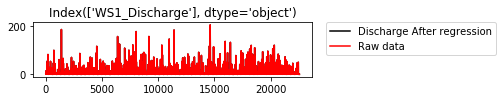

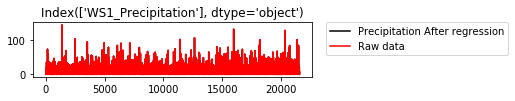

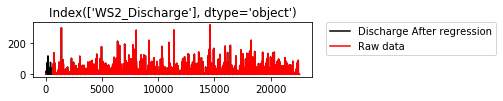

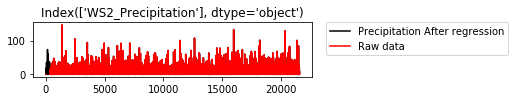

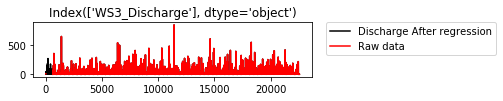

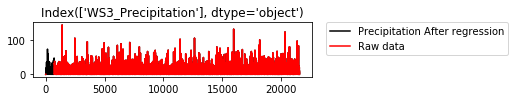

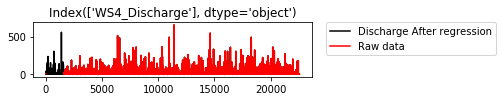

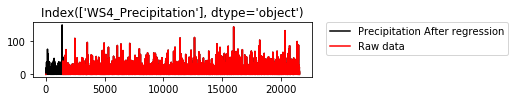

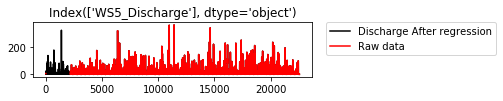

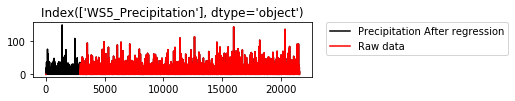

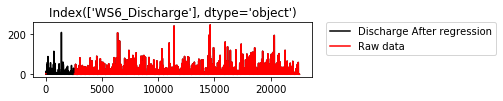

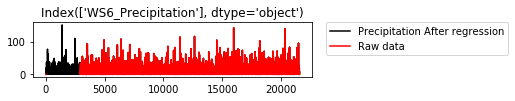

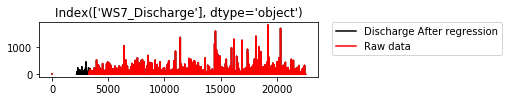

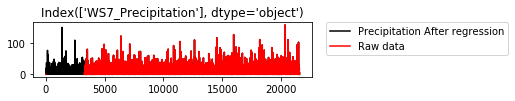

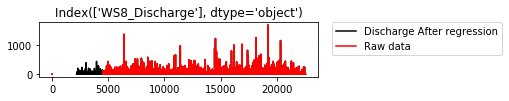

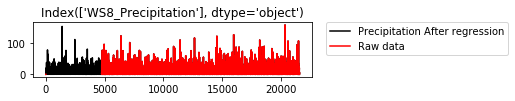

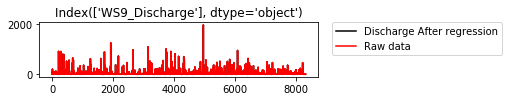

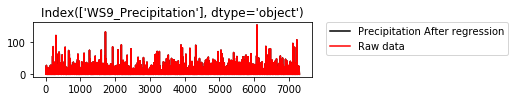

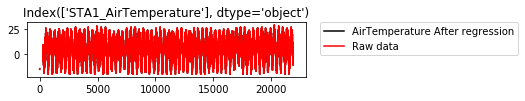

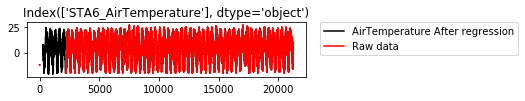

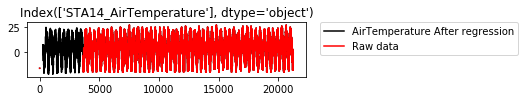

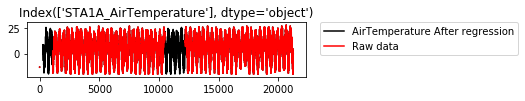

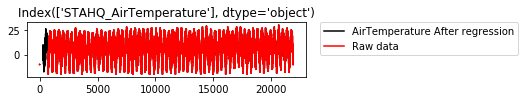

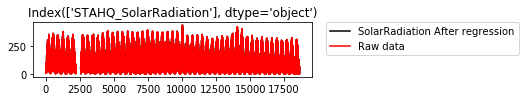

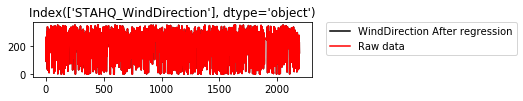

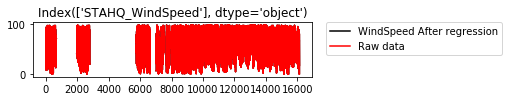

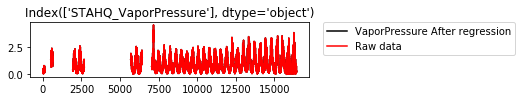

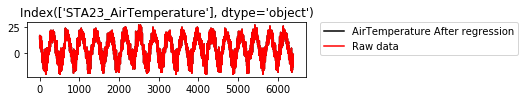

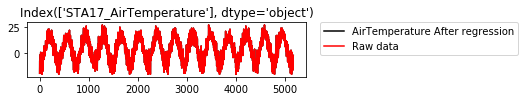

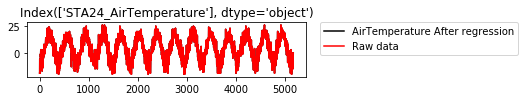

In [17]:
%%time
for i in np.arange(len(stn_names)): # Each met station
    tabReg = stn_table_dic[i]  # extract the table for station i from the dictionary
    for j in np.arange(len(var_names)): # loop across variables, not looping for discharge
        var = var_names[j] # for each meteorology variable
        if var in pd.unique(np.array([c.split('_')[1] for c in tabReg.columns])):
            ind = get_ind(tabReg,var)
            print(i+1,"/",len(stn_names),"in process:",stn_names[i],var)
            # Fill single variable from multiple stations
            nn = fromEveryStationPoolAvariable(stn_names, var, ind, stn_table_dic)
            ## nn is a df storing the all the data for the same variable(var)

            # Do regression across stations for met station i, variable j
            result = regressionAtStationForAvariable(nn, stn_names[i], var)
            regressed_cols = pd.Series(list(set(result.columns) & set(tabReg.columns)),dtype='object') # column where regression is done
            
            # Update table3 with regression results
            #print('Finishing regression on Station', stn_names[i], var) 
            for k in np.arange(len(regressed_cols)):
                rcol=regressed_cols[k]
                reg=result[rcol]
                table3.loc[reg.index[0]:reg.index[-1],rcol] = np.array(reg)
        else:
            print("No",var,"data at station",stn_names[i])
        print(' ')

In [18]:
# Write indicators of regression into flag table
for j in range(len(col_names)):
    col = col_names[j]
    for m in table3[col].index:  
        if str(table2[col][m]) == 'nan':
            if str(table3[col][m])!= 'nan':
                flag_table3[col][m] = int(3)

In [19]:
# Check the regression values and delete out of range values
for col in col_names:
    outvalues(table, table3, flag_table3, col)

No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
WS6_Discharge Less than minimum, value -0.007643157100769439 < 0 index =  2071
WS6_Discharge Less than minimum, value -0.017416907286185945 < 0 index =  2072
WS6_Discharge Less than minimum, value -0.012259104540223054 < 0 index =  2076
WS6_Discharge Less than minimum, value -0.019705052751497115 < 0 index =  2077
WS6_Discharge Less than minimum, value -0.02422519287315473 < 0 index =  2078
WS6_Discharge Less than minimum, value -0.0007190604703109782 < 0 index =  2409
WS6_Discharge Less than minimum, value -0.022901086609256112 < 0 index =  2411
WS6_Discharge Less than minimum, value -0.014337386357028678 < 0 index =  2412
WS6_Discharge Less than minimum, value -0.006482414596702457 < 0 index =  2415
WS6_Discharge Less than minimum, value -0.0287505

No filled values are out of original data range
WS8_Discharge Less than minimum, value -0.2554135760002284 < 0 index =  2722
WS8_Discharge Less than minimum, value -0.4519837300982775 < 0 index =  2723
WS8_Discharge Less than minimum, value -0.5057072469409243 < 0 index =  2724
WS8_Discharge Less than minimum, value -0.6385181714775792 < 0 index =  2725
WS8_Discharge Less than minimum, value -0.34503598560297133 < 0 index =  2726
WS8_Discharge Less than minimum, value -0.005119905059532748 < 0 index =  2727
WS8_Discharge Less than minimum, value -0.3388447996471271 < 0 index =  2729
WS8_Discharge Less than minimum, value -0.2554135760002284 < 0 index =  2735
WS8_Discharge Less than minimum, value -0.4251219716769541 < 0 index =  2736
WS8_Discharge Less than minimum, value -0.6385181714775792 < 0 index =  2737
WS8_Discharge Less than minimum, value -0.7049236337459066 < 0 index =  2738
WS8_Discharge Less than minimum, value -0.7049236337459066 < 0 index =  2739
WS8_Discharge Less than m

WS8_Discharge Less than minimum, value -0.40230242277839423 < 0 index =  3183
WS8_Discharge Less than minimum, value -0.40230242277839423 < 0 index =  3184
WS8_Discharge Less than minimum, value -0.40230242277839423 < 0 index =  3185
WS8_Discharge Less than minimum, value -0.40230242277839423 < 0 index =  3186
WS8_Discharge Less than minimum, value -0.40230242277839423 < 0 index =  3187
WS8_Discharge Less than minimum, value -0.40230242277839423 < 0 index =  3188
WS8_Discharge Less than minimum, value -0.40230242277839423 < 0 index =  3189
WS8_Discharge Less than minimum, value -0.40230242277839423 < 0 index =  3190
WS8_Discharge Less than minimum, value -0.40230242277839423 < 0 index =  3191
WS8_Discharge Less than minimum, value -0.40230242277839423 < 0 index =  3192
WS8_Discharge Less than minimum, value -0.1956032245177845 < 0 index =  3195
WS8_Discharge Less than minimum, value -0.22903293539820202 < 0 index =  3196
WS8_Discharge Less than minimum, value -0.08566185141105925 < 0 i

WS8_Discharge Less than minimum, value -1.0349261990561474 < 0 index =  3863
WS8_Discharge Less than minimum, value -1.0803976645357671 < 0 index =  3864
WS8_Discharge Less than minimum, value -1.0971883646863687 < 0 index =  3865
WS8_Discharge Less than minimum, value -1.0700765586734213 < 0 index =  3866
WS8_Discharge Less than minimum, value -0.845260197834715 < 0 index =  3867
WS8_Discharge Less than minimum, value -1.0661813336244113 < 0 index =  3868
WS8_Discharge Less than minimum, value -1.1547247492440875 < 0 index =  3869
WS8_Discharge Less than minimum, value -1.1797576054002232 < 0 index =  3870
WS8_Discharge Less than minimum, value -1.192530997824108 < 0 index =  3871
WS8_Discharge Less than minimum, value -0.21339695443287598 < 0 index =  3872
WS8_Discharge Less than minimum, value -0.3066400161236691 < 0 index =  3874
WS8_Discharge Less than minimum, value -0.8151537502794151 < 0 index =  3875
WS8_Discharge Less than minimum, value -1.0235385434780013 < 0 index =  3876


WS8_Discharge Less than minimum, value -0.5004226380770842 < 0 index =  4620
WS8_Discharge Less than minimum, value -0.019784120485039525 < 0 index =  4634
WS8_Discharge Less than minimum, value -0.04855172204126501 < 0 index =  4643
WS8_Discharge Less than minimum, value -0.35639855266622766 < 0 index =  4644
WS8_Discharge Less than minimum, value -0.4939719469131182 < 0 index =  4645
WS8_Discharge Less than minimum, value -0.39935353972473964 < 0 index =  4646
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
WS4_Precipitation More than maximum, value 148.67053365298895 > 142.7 index =  1757
WS5_Precipitation More than maximum, value 148.6995263156502 > 142.8 index =  1757
WS6_Precipitation More than maximum, value 151.15464755099802 > 142.5 index =  1757
No filled values are out of original data range
WS8_Precipitation Less than minimum, value

WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  3912
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  3916
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  3917
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  3918
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  3921
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  3922
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  3923
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  3924
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  3925
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  3927
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  3929
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  3930
WS8_

WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4159
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4160
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4161
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4162
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4163
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4164
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4167
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4168
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4169
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4170
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4171
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4172
WS8_

WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4340
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4341
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4342
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4343
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4344
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4345
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4347
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4348
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4352
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4353
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4354
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4355
WS8_

WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4683
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4685
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4686
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4687
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4693
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4695
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4696
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4697
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4702
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4707
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4713
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4717
WS8_

WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4972
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4973
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4974
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4975
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4976
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4978
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4979
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4981
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4982
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4983
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4984
WS8_Precipitation Less than minimum, value -0.009324237958355575 < 0 index =  4985
WS8_

No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range


In [20]:
# Store the data table and the flag table
table3.to_csv('3_'+watershed+'_Regression.csv', sep=',')
flag_table3.to_csv('3_'+watershed+'_Regression_Flag.csv', sep=',')

# 4. Data filling method: Climate Catalog

In [21]:
# Extract discharge table
DischargeTable = pd.DataFrame(index = table3.index)
for i in np.arange(len(nameStrflwStation)):
    DischargeTable[nameStrflwStation[i]+'_Discharge'] = table3.loc[:,nameStrflwStation[i]+'_Discharge']
DischargeTable.head(2)

WS1_Discharge  WS2_Discharge  WS3_Discharge  WS4_Discharge  \
DateTime                                                                 
1955-01-01            NaN            NaN            NaN            NaN   
1955-01-02            NaN            NaN            NaN            NaN   

            WS5_Discharge  WS6_Discharge  WS7_Discharge  WS8_Discharge  \
DateTime                                                                 
1955-01-01            NaN            NaN            NaN            NaN   
1955-01-02            NaN            NaN            NaN            NaN   

            WS9_Discharge  
DateTime                   
1955-01-01            NaN  
1955-01-02            NaN

In [22]:
y3 = {}
for i in np.arange(len(table3.columns)):
    col_name = table3.columns[i]
    range_y3 = np.where(~np.isnan(table3[col_name].to_numpy()))[0]
    start = range_y3[0]
    end = range_y3[-1]
    y3[i] = table3[col_name][start:end+1]
AnT = funcClimateCatalog(table3, y3, 270, watershed, 0.7) # divide the data by year
table4,whereClimateCat = AssembleClimateCatalog(AnT, y3, table3, watershed)

0 WS1_Discharge 0
1 WS2_Discharge 0
2 WS3_Discharge 0
3 WS4_Discharge 0
4 WS5_Discharge 0
5 WS6_Discharge 135
6 WS7_Discharge 0
7 WS8_Discharge 377
8 WS9_Discharge 0
9 WS1_Precipitation 0
10 WS2_Precipitation 0
11 WS3_Precipitation 0
12 WS4_Precipitation 1
13 WS5_Precipitation 1
14 WS6_Precipitation 1
15 WS7_Precipitation 0
16 WS8_Precipitation 7
17 WS9_Precipitation 0
18 STA1_AirTemperature 0
19 STA6_AirTemperature 6
20 STA14_AirTemperature 11
21 STA1A_AirTemperature 0
22 STAHQ_AirTemperature 0
23 STA23_AirTemperature 0
24 STA17_AirTemperature 0
25 STA24_AirTemperature 0
26 STAHQ_SolarRadiation 6
27 STAHQ_WindDirection 6
28 STAHQ_WindSpeed 207
29 STAHQ_VaporPressure 79


In [23]:
# Write indicators of ClimateCatalog into flag table4
flag_table4 = copy.deepcopy(flag_table3)
for j in range(len(col_names)):
    col = col_names[j]
    for m in table4[col].index:  
        if str(table3[col][m]) == 'nan':
            if str(table4[col][m])!= 'nan':
                flag_table4[col][m] = int(4)

In [24]:
# Check the regression values and delete out of range values
for col in col_names:
    outvalues(table, table4, flag_table4, col)

No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original data range
No filled values are out of original dat

In [25]:
# Store the data table and the flag table
table4.to_csv('4_'+watershed+'_ClimateCatalog.csv', sep=',')
flag_table4.to_csv('4_'+watershed+'_ClimateCatalog_Flag.csv', sep=',')

In [26]:
table4.head()

WS1_Discharge  WS2_Discharge  WS3_Discharge  WS4_Discharge  \
DateTime                                                                 
1955-01-01            NaN            NaN            NaN            NaN   
1955-01-02            NaN            NaN            NaN            NaN   
1955-01-03            NaN            NaN            NaN            NaN   
1955-01-04            NaN            NaN            NaN            NaN   
1955-01-05            NaN            NaN            NaN            NaN   

            WS5_Discharge  WS6_Discharge  WS7_Discharge  WS8_Discharge  \
DateTime                                                                 
1955-01-01            NaN            NaN            NaN            NaN   
1955-01-02            NaN            NaN            NaN            NaN   
1955-01-03            NaN            NaN            NaN            NaN   
1955-01-04            NaN            NaN            NaN            NaN   
1955-01-05            NaN            NaN            NaN            NaN   

            WS9_Discharge  WS1_Precipitation  ...  STA14_AirTemperature  \
DateTime                                      ...                         
1955-01-01            NaN                NaN  ...            -16.000000   
1955-01-02            NaN                NaN  ...            -15.999179   
1955-01-03            NaN                NaN  ...            -15.998358   
1955-01-04            NaN                NaN  ...            -15.997536   
1955-01-05            NaN                NaN  ...            -15.996715   

            STA1A_AirTemperature  STAHQ_AirTemperature  STA23_AirTemperature  \
DateTime                                                                       
1955-01-01            -13.000000            -10.000000                   NaN   
1955-01-02            -12.989964            -10.010944                   NaN   
1955-01-03            -12.979927            -10.021888                   NaN   
1955-01-04            -12.969891            -10.032832                   NaN   
1955-01-05            -12.959854            -10.043776                   NaN   

            STA17_AirTemperature  STA24_AirTemperature  STAHQ_SolarRadiation  \
DateTime                                                                       
1955-01-01                   NaN                   NaN                   NaN   
1955-01-02                   NaN                   NaN                   NaN   
1955-01-03                   NaN                   NaN                   NaN   
1955-01-04                   NaN                   NaN                   NaN   
1955-01-05                   NaN                   NaN                   NaN   

            STAHQ_WindDirection  STAHQ_WindSpeed  STAHQ_VaporPressure  
DateTime                                                               
1955-01-01                  NaN              NaN                  NaN  
1955-01-02                  NaN              NaN                  NaN  
1955-01-03                  NaN              NaN                  NaN  
1955-01-04                  NaN              NaN                  NaN  
1955-01-05                  NaN              NaN                  NaN  

[5 rows x 30 columns]

In [27]:
flag_table4.head()

WS1_Discharge  WS2_Discharge  WS3_Discharge  WS4_Discharge  \
DateTime                                                                 
1955-01-01            NaN            NaN            NaN            NaN   
1955-01-02            NaN            NaN            NaN            NaN   
1955-01-03            NaN            NaN            NaN            NaN   
1955-01-04            NaN            NaN            NaN            NaN   
1955-01-05            NaN            NaN            NaN            NaN   

            WS5_Discharge  WS6_Discharge  WS7_Discharge  WS8_Discharge  \
DateTime                                                                 
1955-01-01            NaN            NaN            NaN            NaN   
1955-01-02            NaN            NaN            NaN            NaN   
1955-01-03            NaN            NaN            NaN            NaN   
1955-01-04            NaN            NaN            NaN            NaN   
1955-01-05            NaN            NaN            NaN            NaN   

            WS9_Discharge  WS1_Precipitation  ...  STA14_AirTemperature  \
DateTime                                      ...                         
1955-01-01            NaN                NaN  ...                   1.0   
1955-01-02            NaN                NaN  ...                   2.0   
1955-01-03            NaN                NaN  ...                   2.0   
1955-01-04            NaN                NaN  ...                   2.0   
1955-01-05            NaN                NaN  ...                   2.0   

            STA1A_AirTemperature  STAHQ_AirTemperature  STA23_AirTemperature  \
DateTime                                                                       
1955-01-01                   1.0                   1.0                   NaN   
1955-01-02                   2.0                   2.0                   NaN   
1955-01-03                   2.0                   2.0                   NaN   
1955-01-04                   2.0                   2.0                   NaN   
1955-01-05                   2.0                   2.0                   NaN   

            STA17_AirTemperature  STA24_AirTemperature  STAHQ_SolarRadiation  \
DateTime                                                                       
1955-01-01                   NaN                   NaN                   NaN   
1955-01-02                   NaN                   NaN                   NaN   
1955-01-03                   NaN                   NaN                   NaN   
1955-01-04                   NaN                   NaN                   NaN   
1955-01-05                   NaN                   NaN                   NaN   

            STAHQ_WindDirection  STAHQ_WindSpeed  STAHQ_VaporPressure  
DateTime                                                               
1955-01-01                  NaN              NaN                  NaN  
1955-01-02                  NaN              NaN                  NaN  
1955-01-03                  NaN              NaN                  NaN  
1955-01-04                  NaN              NaN                  NaN  
1955-01-05                  NaN              NaN                  NaN  

[5 rows x 30 columns]

In [28]:
table4.shape

(22927, 30)

In [29]:
flag_table4.shape

(22927, 30)